In [1]:
import gudhi as gd
from gudhi import representations
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
#import pingouin as pg
import scipy.stats as st
from collections import defaultdict
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import paired_distances
from tqdm.notebook import tqdm
import scipy.spatial.distance as spdists
#from curlyBrace import curlyBrace
%matplotlib inline

In [2]:
#scipy.stats uses numpy.random seed
np.random.seed(seed=0)

In [3]:
def sampled_ecc_alpha(pointcloud, n_samples, max_filt_val):
    ac = gd.AlphaComplex(points = pointcloud)
    st = ac.create_simplex_tree()
    filt_values = np.linspace(0,max_filt_val,n_samples)
    ecc_values = np.zeros_like(filt_values)
    simplices = list(st.get_filtration())
    cur_val = 0
    i=0
    for (j,t) in enumerate(filt_values):
        while (i<len(simplices)) and (simplices[i][1]<=t):
            cur_val=cur_val +(-1)**(len(simplices[i][0])-1)
            i = i+1
        #print(t, cur_val)
        ecc_values[j] = cur_val
        
    return ecc_values/np.sqrt(len(pointcloud))

In [4]:
def get_ecc(data, n_samples, max_filt_val):
    eccs = []
    for dat in tqdm(data):
        ec = sampled_ecc_alpha(dat, n_samples, max_filt_val)
        eccs.append(ec)
    return eccs

In [5]:
class UniformMixture:
    def __init__(self, locations, scales, probas):
        # locations - vector of location parameters
        # scales - vector of scale parameters
        # probas - vector of mixture coefficients
        if not (len(locations) == len(scales) and len(scales) == len(probas)):
            raise ValueError("Wrong number of components for Gaussian Mixture")
        self.locations = locations
        self.scales = scales
        self.n_uniforms = len(locations)
        self.unif_rv = [st.uniform(loc, scale) for loc, scale in zip(locations, scales)]
        probas_sum = np.sum(probas)
        probas = [proba / probas_sum for proba in probas]
        self.probas = probas

    # draw sample from GaussianMixture model
    def rvs(self, N):
        inds = st.rv_discrete(values=(range(self.n_uniforms), self.probas)).rvs(size=N)
        X = [self.unif_rv[ind].rvs(size=1)[0] for ind in inds]
        return X

    def cdf(self, x):
        cdf = 0
        for p, rv in zip(self.probas, self.unif_rv):
            cdf += p * rv.cdf(x)
        return cdf

    def pdf(self, x):
        pdf = 0
        for p, rv in zip(self.probas, self.unif_rv):
            pdf += p * rv.pdf(x)
        return pdf

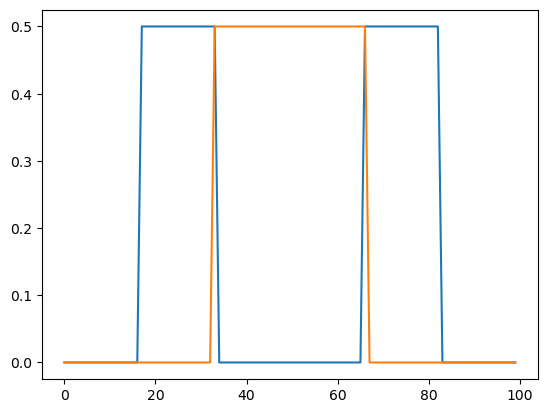

In [6]:
two = UniformMixture([-2,1],[1,1],[0.5,0.5])
one = st.uniform(-1,2)
f,ax = plt.subplots()
ax.plot(two.pdf(np.linspace(-3,3,100)))
ax.plot(one.pdf(np.linspace(-3,3,100)))
plt.show()

In [7]:
n=50
n_loops = 1000
d = 1
steps = 50001
maxfilt = 2500

In [8]:
samples_one = [n*np.array([[s] for s in one.rvs(n)]) for i in range(0,n_loops)]


In [9]:
ecc_one = get_ecc(samples_one, steps, maxfilt)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [10]:
avg_ecc_one = np.mean(ecc_one, axis = 0)
ecc_one = get_ecc(samples_one, steps, maxfilt)
L1_dists = pairwise_distances([avg_ecc_one], ecc_one, metric = "minkowski", p=1, n_jobs = -1)
L1_dists = L1_dists*(maxfilt/(steps-1))
L1_quant = np.quantile(L1_dists, 0.95)
sup_dists = pairwise_distances([avg_ecc_one], ecc_one, metric = "chebyshev", n_jobs = -1)
sup_quant = np.quantile(sup_dists, 0.95)

print(sup_quant, L1_quant)

  0%|          | 0/1000 [00:00<?, ?it/s]

0.9777872570247484 6.083782696555911


In [11]:
ecc_two = sampled_ecc_alpha(n*np.array([[s] for s in two.rvs(n)]),steps, maxfilt)
ecc_one2 = sampled_ecc_alpha(n*np.array([[s] for s in one.rvs(n)]),steps, maxfilt)

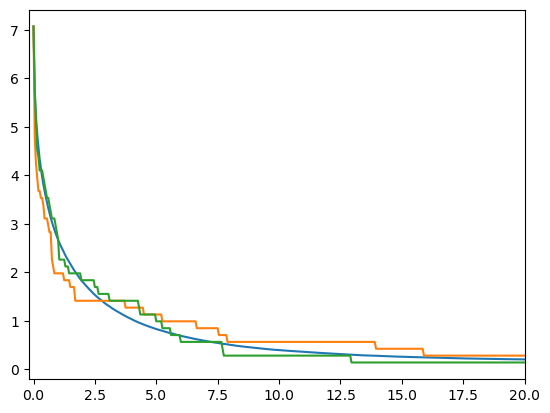

In [12]:
t= np.linspace(0,maxfilt,steps)
f,ax = plt.subplots()
ax.plot(t,avg_ecc_one)
ax.plot(t,ecc_two)
ax.plot(t,ecc_one2)
ax.set_xlim((-0.2,20))
#ax.set_ylim((0,7))
plt.show()

In [13]:
sup_test = pairwise_distances([avg_ecc_one], [ecc_one2, ecc_two], metric = "chebyshev")
L1_test = pairwise_distances([avg_ecc_one], [ecc_one2, ecc_two], metric = "minkowski", p=1)*(maxfilt/(steps-1))
print(sup_test, L1_test)

print("sup test accepts H0:",sup_test<sup_quant)
print("L1 test accepts H0:",L1_test<L1_quant)

[[0.44279027 0.97099903]] [[  3.06253604 354.36826045]]
sup test accepts H0: [[ True  True]]
L1 test accepts H0: [[ True False]]
